# Projet IA HumanForYou


|Auteur|
|---|
|Victor Massotte|
|Quentin Butel|
|Lyna Selam|
|Arthur Oliveira|
|Guillaume Langlois|

## Contexte

La direction fait donc appel à vous, spécialistes de l'analyse de données, pour déterminer les facteurs ayant le plus d'influence sur ce taux de turn-over et lui proposer des modèles afin d'avoir des pistes d'amélioration pour donner à leurs employés l'envie de rester.

##  1. Préparation des données

### A. Initialisation du projet

In [151]:
# imports
import numpy as np
import seaborn as sns
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### B. Importation

In [152]:
import os
import pandas as pd

dataSets_Path = os.path.join(".\datasets")

generalData = pd.read_csv(os.path.join(dataSets_Path, "general_data.csv"))
employeeData = pd.read_csv(os.path.join(dataSets_Path, "employee_survey_data.csv"))
managerData = pd.read_csv(os.path.join(dataSets_Path, "manager_survey_data.csv"))
intTimeData = pd.read_csv(os.path.join(dataSets_Path, "in_time.csv"))
outTimeData = pd.read_csv(os.path.join(dataSets_Path, "out_time.csv"))



On va transfomer tous les objets contenus dans les tableaux `in_time` et `out_time` en datetime afin de pouvoir les utiliser pour des opérations

In [153]:
intTimeData=intTimeData.replace(np.nan,0)
intTimeData.iloc[:, 1:] = intTimeData.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')
outTimeData=outTimeData.replace(np.nan,0)
outTimeData.iloc[:, 1:] = outTimeData.iloc[:, 1:].apply(pd.to_datetime, errors='coerce')

intTimeData=intTimeData.append(outTimeData)

intTimeData=intTimeData.diff(periods=4410)
intTimeData=intTimeData.iloc[4410:]
intTimeData.reset_index(inplace=True)
intTimeData.drop(columns=['index','Unnamed: 0'],axis=1,inplace=True)

intTimeData.drop(['2015-01-01', '2015-01-14','2015-01-26','2015-03-05',
             '2015-05-01','2015-07-17','2015-09-17','2015-10-02',
              '2015-11-09','2015-11-10','2015-11-11','2015-12-25'
             ], axis = 1,inplace=True) 




In [154]:
intTimeData['Actual Time']=intTimeData.mean(axis=1)
intTimeData['hrs']=intTimeData['Actual Time']/np.timedelta64(1, 'h')
intTimeData.reset_index(inplace=True)
intTimeData.drop(intTimeData.columns.difference(['index','hrs']), 1, inplace=True)
intTimeData.rename(columns={'index': 'EmployeeID'},inplace=True)

In [155]:
intTimeData.head()

,EmployeeID,hrs
0,0,6.870229
1,1,7.315971
2,2,6.816081
3,3,6.789215
4,4,7.877561


Nous allons supprimer les données suivantes, car elles sont toutes les memes et ne sont pas pertinentes :
* EmployeeID
* Over18
* EmployeeCount
* StandardHours

Nous allons aussi supprimer les données que nous trouvons non éthiques : 
* MaritalStatus
* Gender
* StockOptionLevel

In [156]:
allData = pd.merge(employeeData, generalData, how='inner', on=['EmployeeID'])
allData = allData.merge(managerData, how='inner', on=['EmployeeID'])
allData = allData.merge(intTimeData, how='inner', on=['EmployeeID'])

""" allData = allData.merge(intTimeData, how='inner', on=['EmployeeID'])
allData = allData.merge(outTimeData, how='inner', on=['EmployeeID']) """

allData.drop("EmployeeID", axis=1, inplace=True) #useless
allData.drop("Over18", axis=1, inplace=True) #useless
allData.drop("EmployeeCount", axis=1, inplace=True) #useless
allData.drop("StandardHours", axis=1, inplace=True) #useless

allData.drop("MaritalStatus", axis=1, inplace=True) #ethic
allData.drop("Gender", axis=1, inplace=True) #ethic
allData.drop("StockOptionLevel", axis=1, inplace=True) #ethic

Test = allData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4409 entries, 0 to 4408
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EnvironmentSatisfaction  4384 non-null   float64
 1   JobSatisfaction          4389 non-null   float64
 2   WorkLifeBalance          4372 non-null   float64
 3   Age                      4409 non-null   int64  
 4   Attrition                4409 non-null   object 
 5   BusinessTravel           4409 non-null   object 
 6   Department               4409 non-null   object 
 7   DistanceFromHome         4409 non-null   int64  
 8   Education                4409 non-null   int64  
 9   EducationField           4409 non-null   object 
 10  JobLevel                 4409 non-null   int64  
 11  JobRole                  4409 non-null   object 
 12  MonthlyIncome            4409 non-null   int64  
 13  NumCompaniesWorked       4390 non-null   float64
 14  PercentSalaryHike       

### C. Remplissage des données ordinales

In [157]:
incomplete_variables = ["JobSatisfaction","EnvironmentSatisfaction","WorkLifeBalance"]
for variable in incomplete_variables:
	median = allData[variable].median()
	allData[variable].fillna(median, inplace=True)

### D. Decode valeur

Nous allons modifier les données suivantes pour avoir des resultats plus facile à analyser :
* PerformanceRating
* EnvironmentSatisfaction
* JobSatisfaction
* JobInvolvement
* WorkLifeBalance
* Education
* JobLeve

In [158]:
allData['PerformanceRating'] = allData['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
allData['EnvironmentSatisfaction'] = allData['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobSatisfaction'] = allData['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobInvolvement'] = allData['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['WorkLifeBalance'] = allData['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})
allData['Education'] = allData['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
allData['JobLevel'] = allData["JobLevel"].replace({ 1 : 'Apprentice', 2: 'Junior Employee',3: 'Employee',4: 'Manager',5 : 'Director'})

In [159]:
allData.describe(include="all")

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,...,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,hrs
count,4409,4409,4409,4409.000000,4409,4409,4409,4409.000000,4409,4409,...,4390.000000,4409.000000,4401.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409,4409,4409.000000
unique,4,4,4,NaN,2,3,3,NaN,5,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,NaN
top,High,Very High,Better,NaN,No,Travel_Rarely,Research & Development,NaN,Bachelor,Life Sciences,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,Excellent,NaN
freq,1375,1367,2697,NaN,3698,3128,2882,NaN,1715,1818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2604,3731,NaN
mean,NaN,NaN,NaN,36.923112,NaN,NaN,NaN,9.188251,NaN,NaN,...,2.695444,15.210252,11.279936,2.798594,7.004990,2.187571,4.122023,NaN,NaN,7.314463
std,NaN,NaN,NaN,9.134220,NaN,NaN,NaN,8.100992,NaN,NaN,...,2.498840,3.659203,7.782222,1.288222,6.122203,3.222042,3.566975,NaN,NaN,1.330903
min,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,1.000000,NaN,NaN,...,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,5.416880
25%,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,2.000000,NaN,NaN,...,1.000000,12.000000,6.000000,2.000000,3.000000,0.000000,2.000000,NaN,NaN,6.278995
50%,NaN,NaN,NaN,36.000000,NaN,NaN,NaN,7.000000,NaN,NaN,...,2.000000,14.000000,10.000000,3.000000,5.000000,1.000000,3.000000,NaN,NaN,7.011237
75%,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,14.000000,NaN,NaN,...,4.000000,18.000000,15.000000,3.000000,9.000000,3.000000,7.000000,NaN,NaN,7.900932


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>,
        <AxesSubplot:title={'center':'MonthlyIncome'}>],
       [<AxesSubplot:title={'center':'NumCompaniesWorked'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>],
       [<AxesSubplot:title={'center':'TrainingTimesLastYear'}>,
        <AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>],
       [<AxesSubplot:title={'center':'YearsWithCurrManager'}>,
        <AxesSubplot:title={'center':'hrs'}>, <AxesSubplot:>]],
      dtype=object)

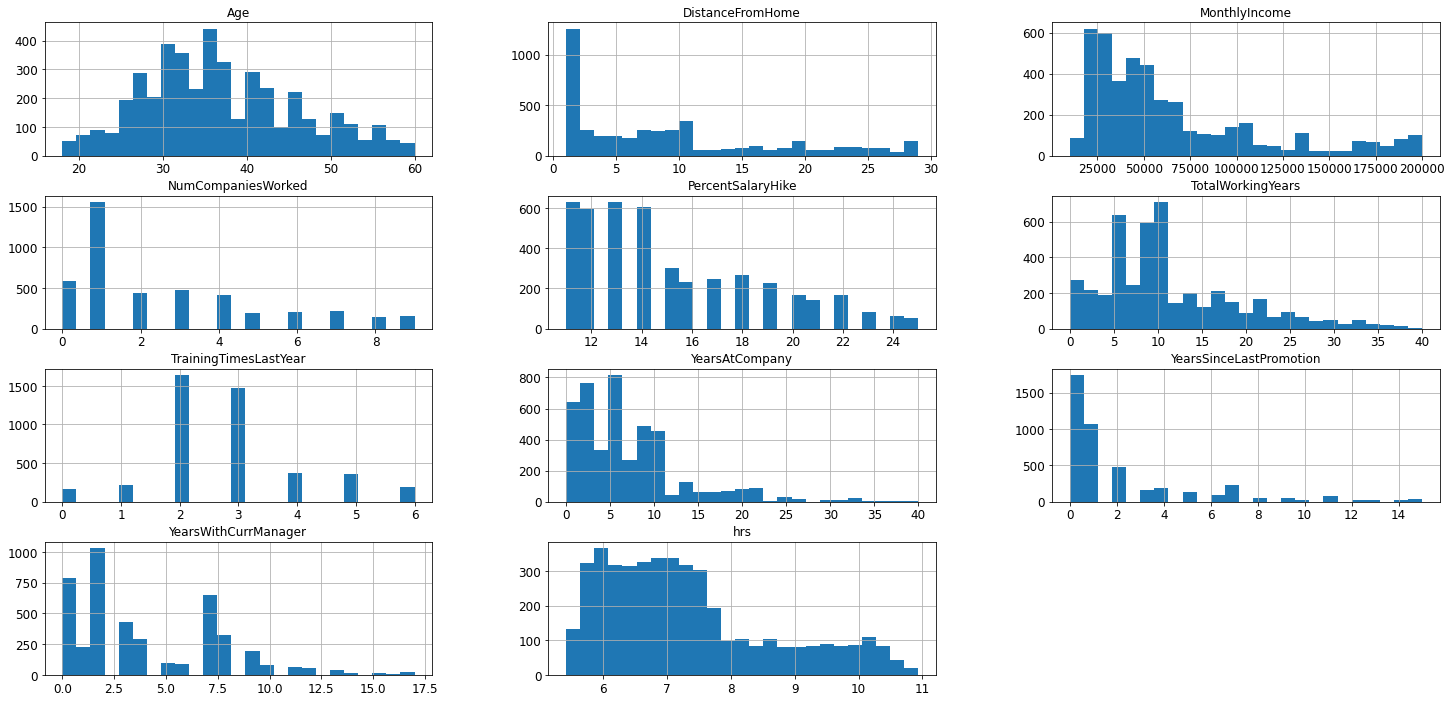

In [160]:
allData.hist(figsize=(25,12), bins=25,column=list(allData.columns))

##  2. Pré-traitement des données


### A. Analyse des variables



#### Analyse de toutes les variables qualitatives

Vous trouverez en dessous tous les graphes avec les variables de type `object` du jeu de données.

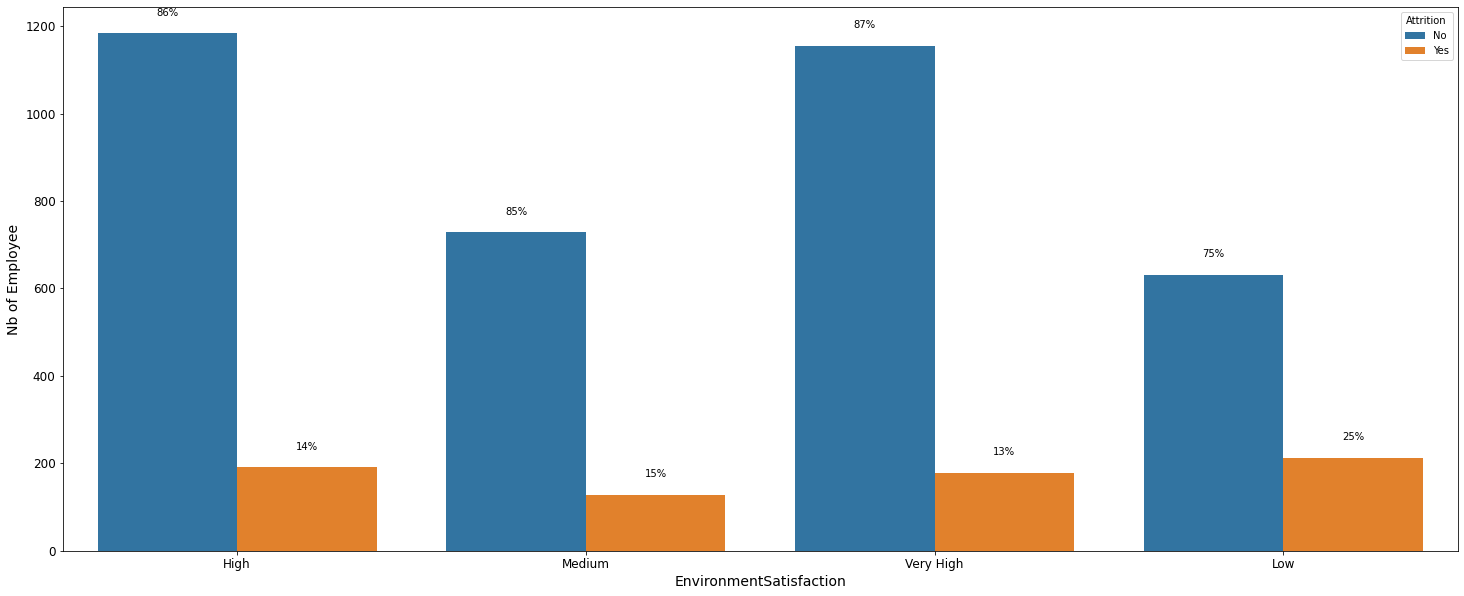

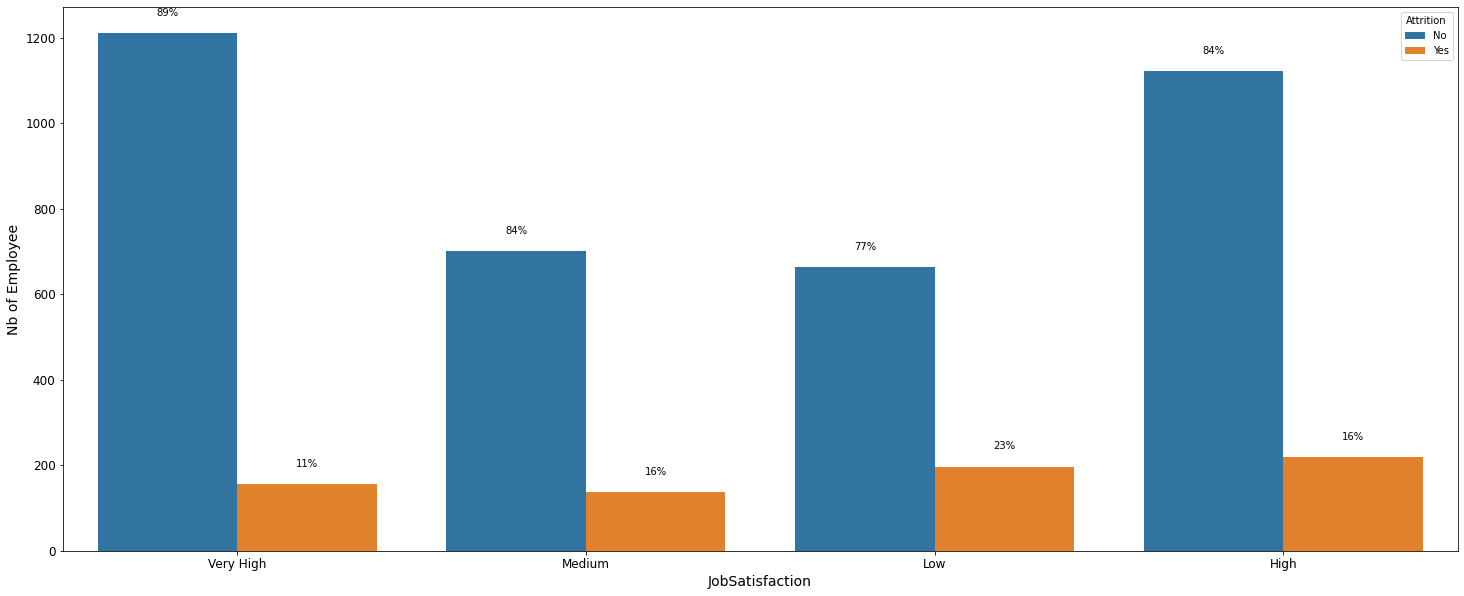

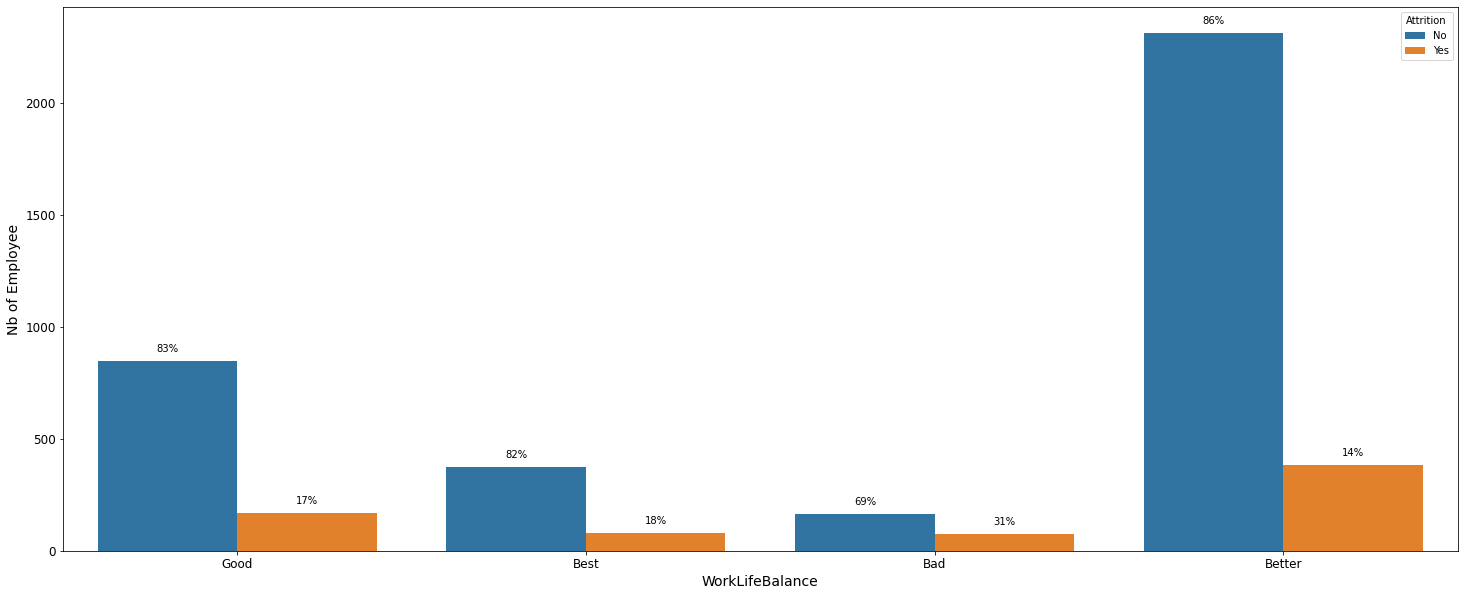

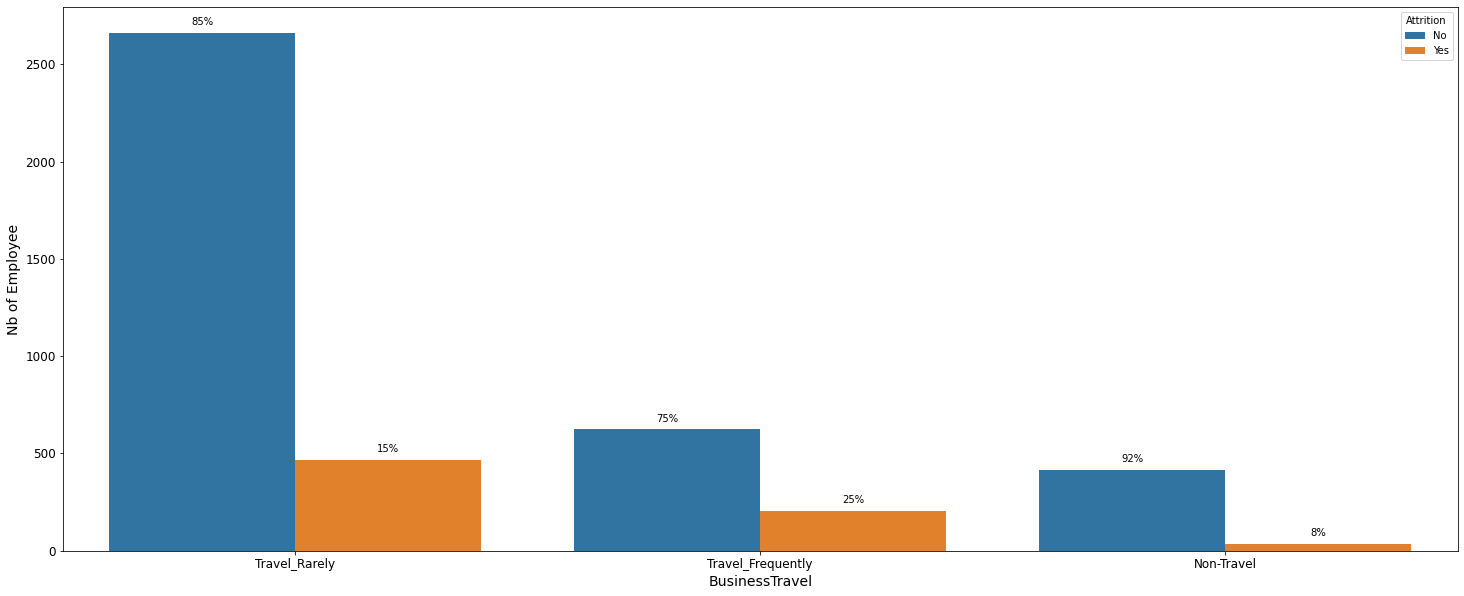

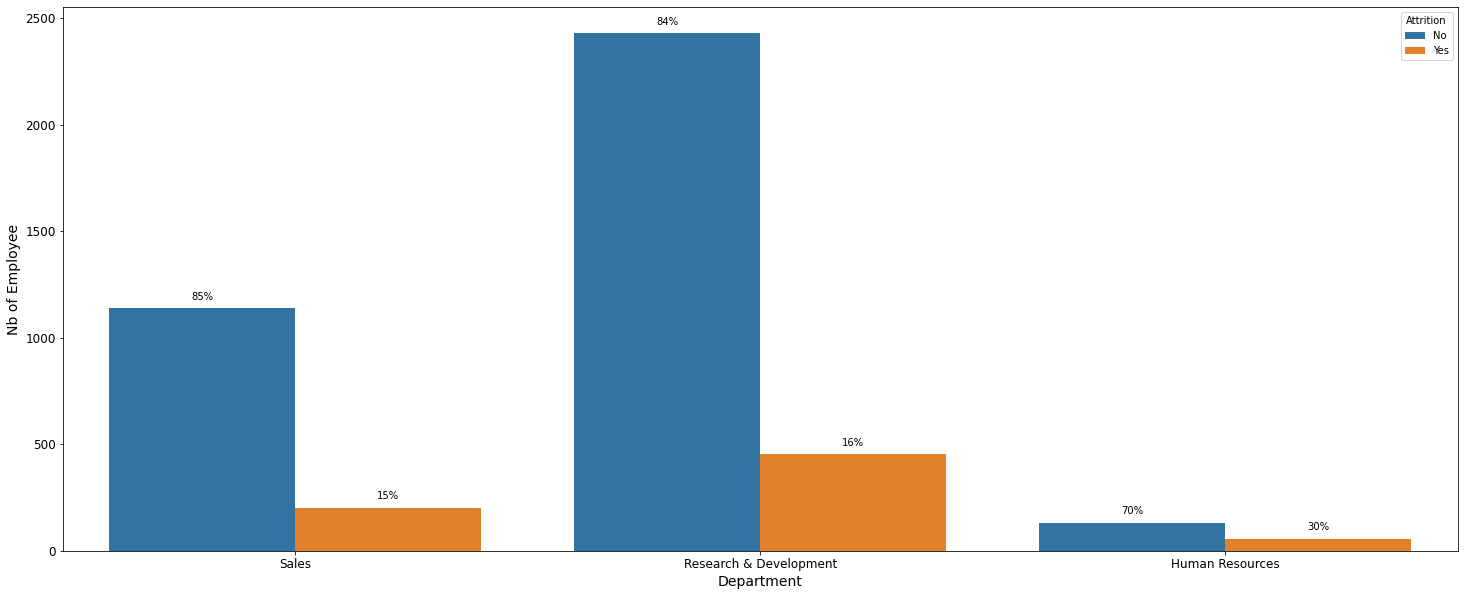

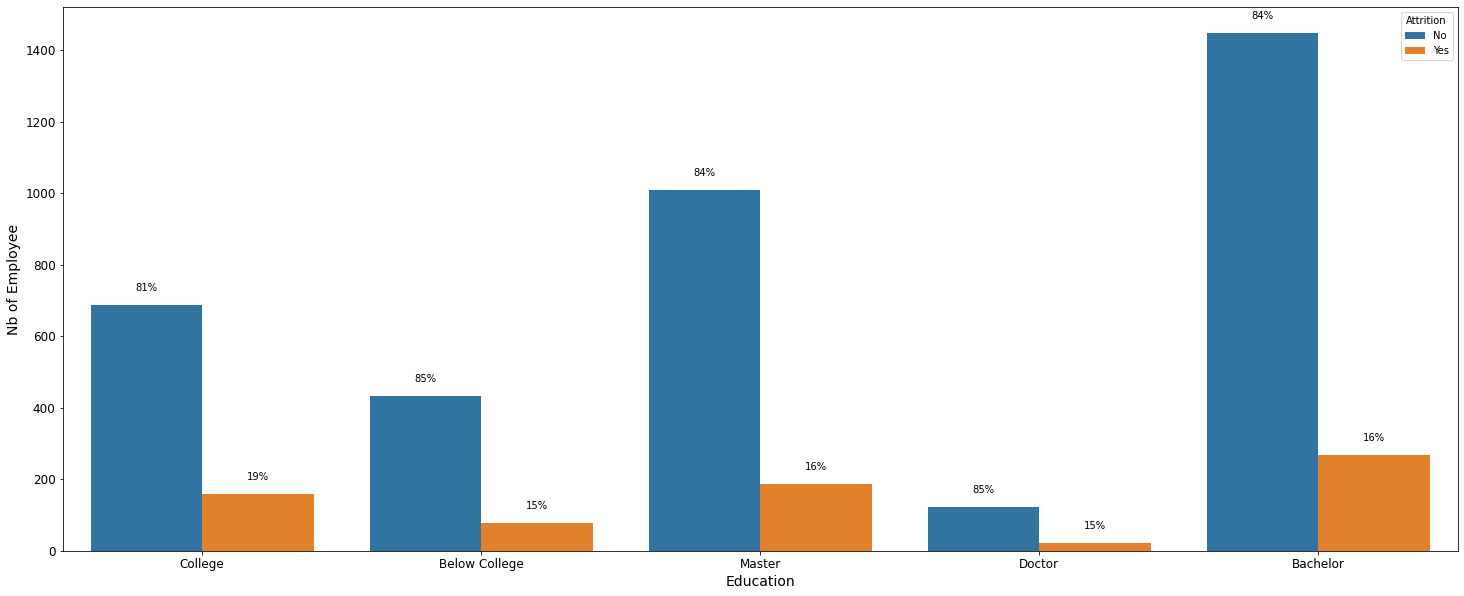

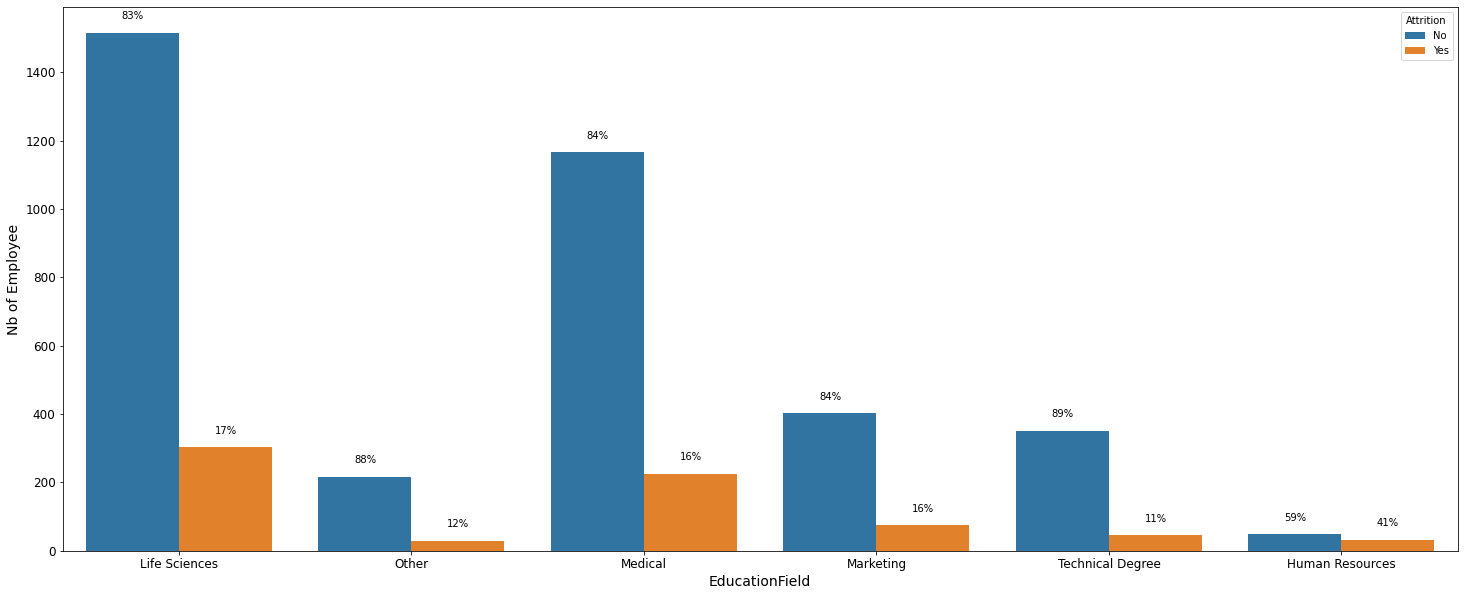

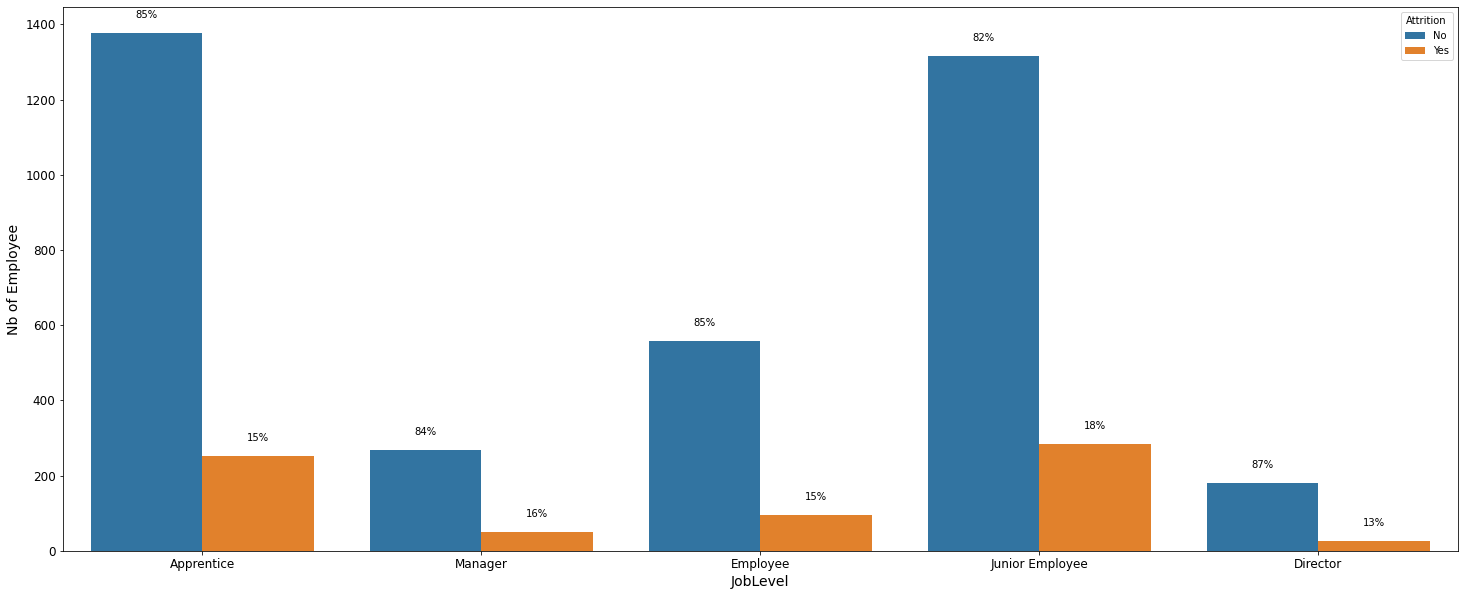

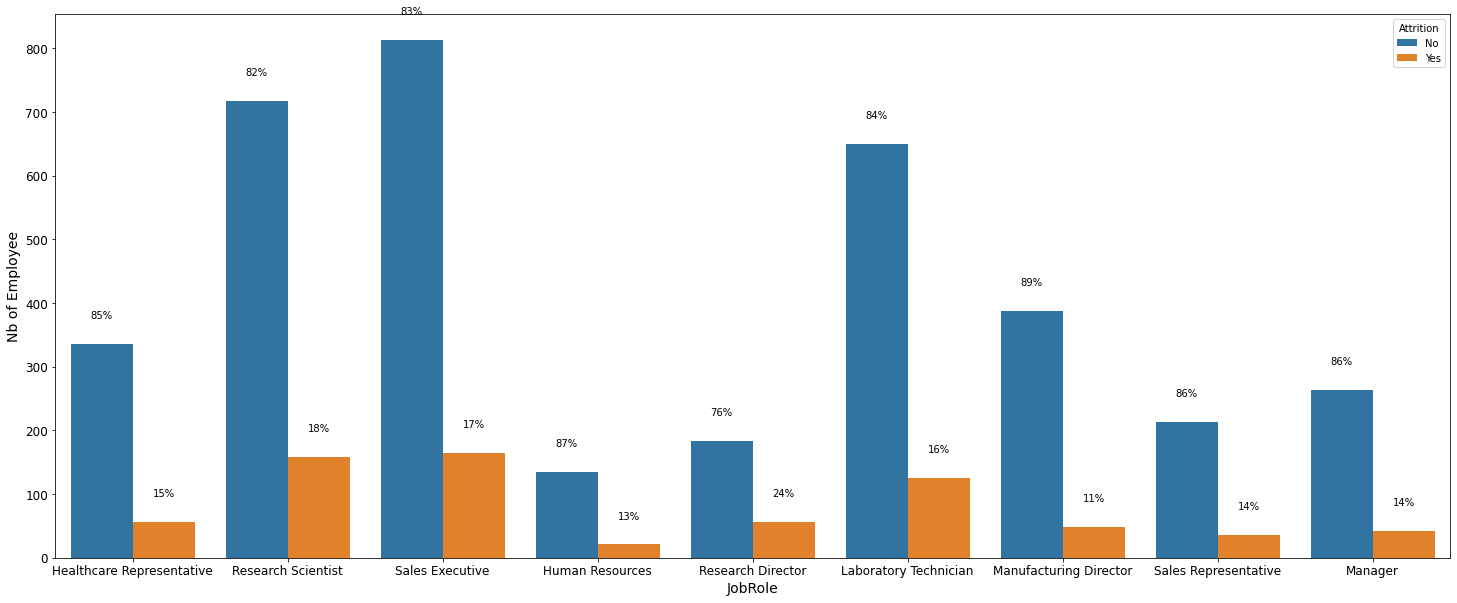

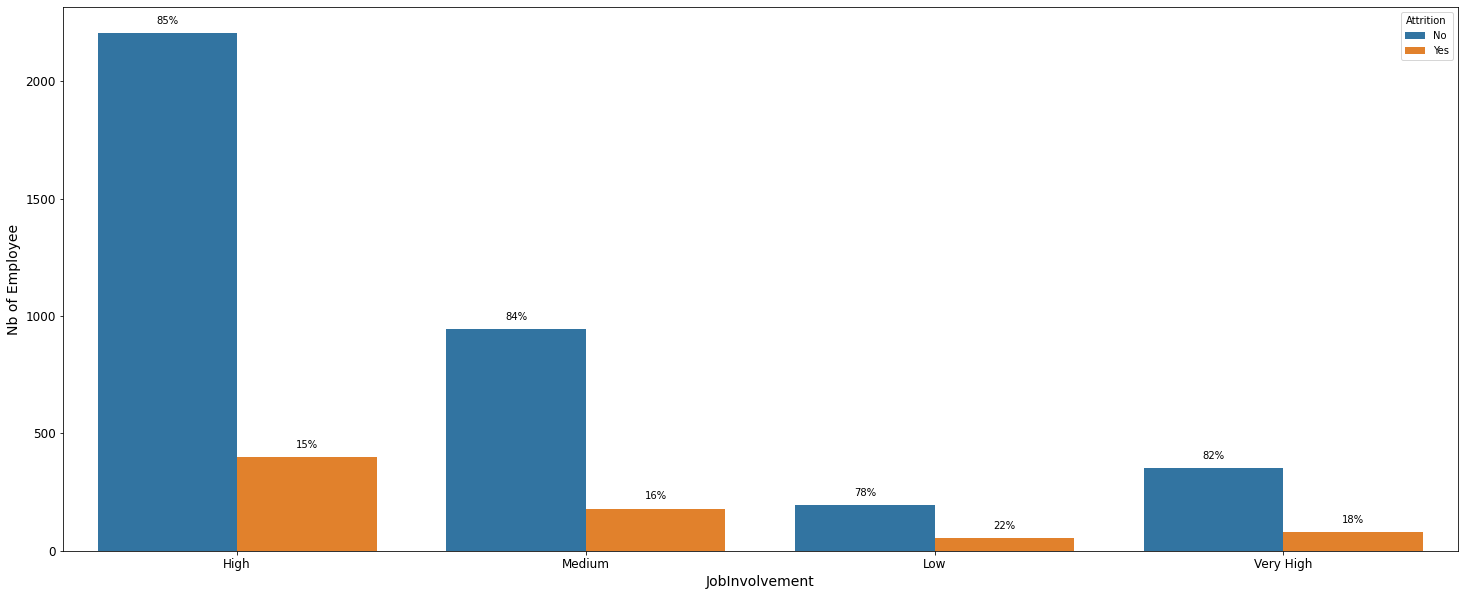

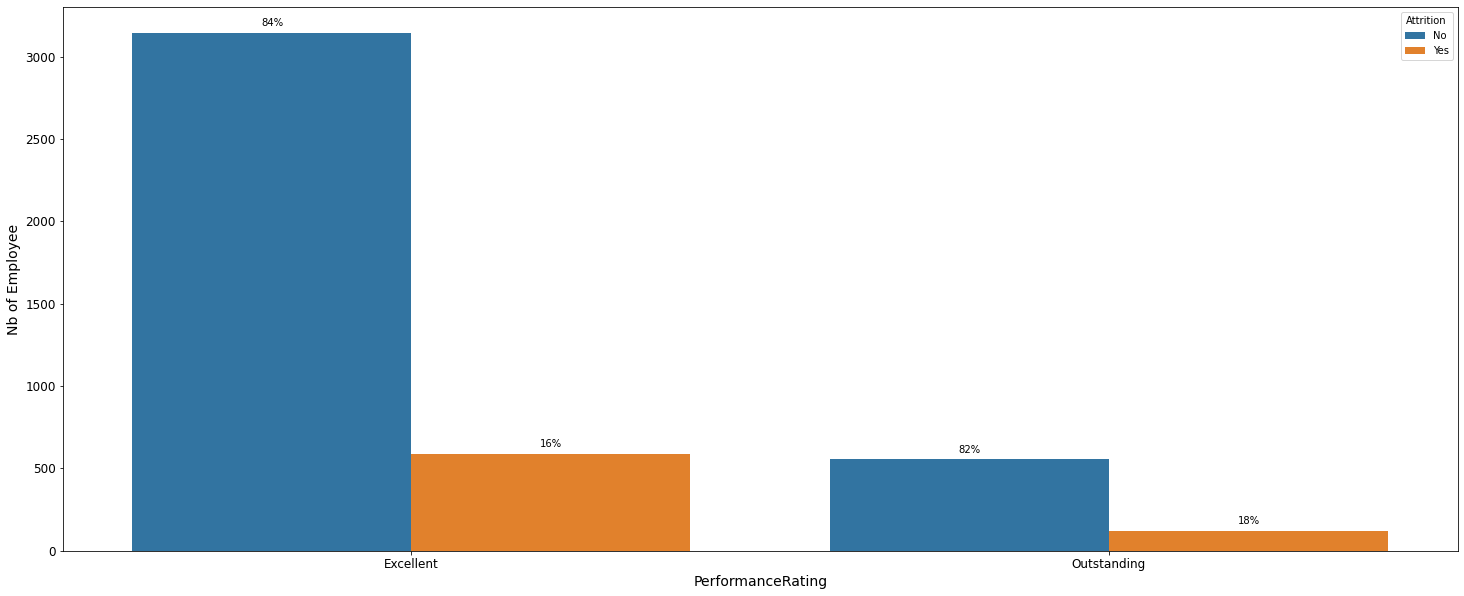

In [161]:
for name_column in allData.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        plt.figure(figsize=(25,10))
        ax = sns.countplot(x=name_column, data=allData, hue="Attrition")
        ax.set_ylabel('Nb of Employee')
        bars = ax.patches
        half = int(len(bars)/2)
        left_bars = bars[:half]
        right_bars = bars[half:]

        for left, right in zip(left_bars, right_bars):
            height_l = left.get_height()
            height_r = right.get_height()
            total = height_l + height_r

            ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
            ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

#### Analyse de toutes les variables quantitatives

Vous trouverez en dessous tous les graphes avec les variables de type `number` du jeu de données.

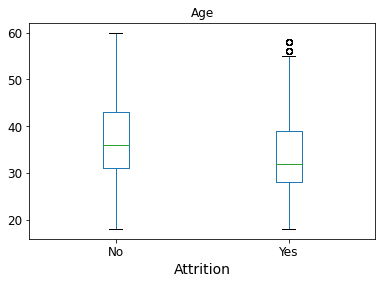

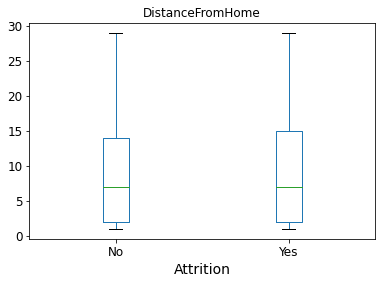

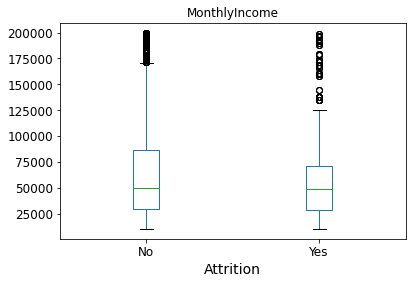

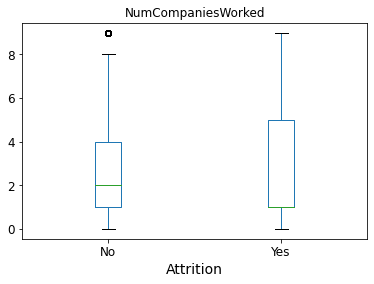

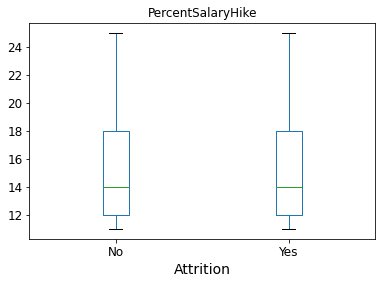

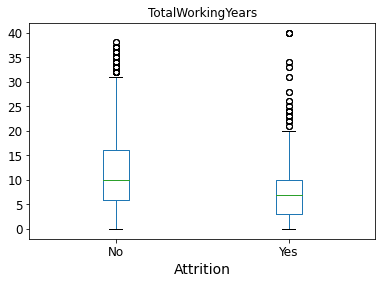

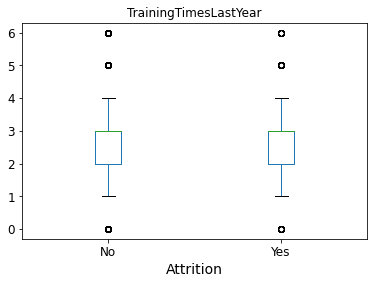

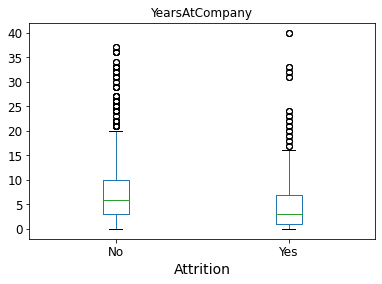

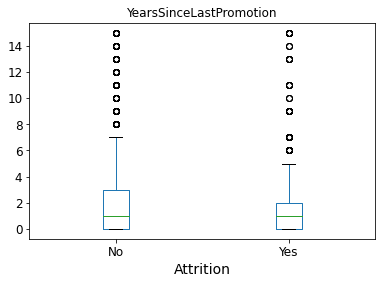

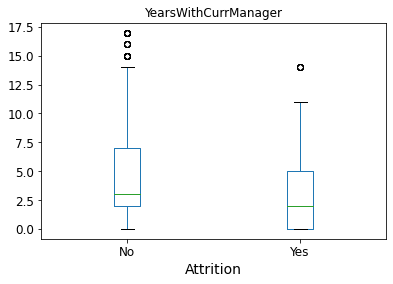

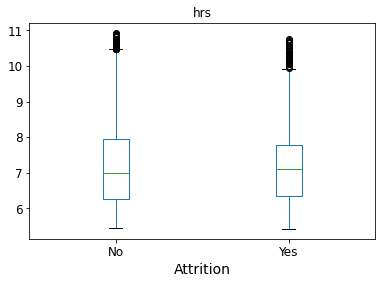

In [162]:
for name_column in allData.select_dtypes(np.number).columns:
    allData.boxplot(by ='Attrition', column = name_column, grid = False, figsize=None) 
    plt.suptitle("")

### Conclusion de l'analyse de données.
    
En analysant les graphiques, on peut émettre l'analyse qu'il semblerait que l'âge ainsi que le nombre d'années dans l'entreprise sont liés au départ des employées.

### B. Test des données

Nous allons utiliser deux tests différents afin de tester la dépendance de la variable attrition avec les autres. <br>
On utilise donc `Anova` lorsque la deuxième variable est quantitative et `Khi2` lorsque la deuxième variable est qualitative. Ces tests nous renvoient deux données. La première est la valeur du test et la seconde est la p-value. Cette dernière nous permet d'évaluer la dépendance. Si la p-value est inférieur à 5%, cela veut dire que nous pouvons rejeter l'hypothèse d'indépendance et donc que l'attrition dépend de la variable  choisie.

#### Anova

In [163]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for name_column in allData.select_dtypes(include=np.number).columns:
    test_anova = name_column + ' ~ Attrition'
    model = ols(test_anova, data=allData).fit()
    result_anova = sm.stats.anova_lm(model, typ=2)
    print(name_column, "= F : ", result_anova["F"][0], ", p_value : ", result_anova["PR(>F)"][0], "\033[32mDépendant\033[0m" if result_anova["PR(>F)"][0] < 0.05 else "\033[31mIndépendant\033[0m")

Age = F :  114.5643529785228 , p_value :  2.0643297829987788e-26 Dépendant
DistanceFromHome = F :  0.39821885930449846 , p_value :  0.5280432738303005 Indépendant
MonthlyIncome = F :  4.293854455865298 , p_value :  0.03830837896884729 Dépendant
NumCompaniesWorked = F :  7.844753196464542 , p_value :  0.0051191555746321225 Dépendant
PercentSalaryHike = F :  4.645159524851116 , p_value :  0.031195233418440483 Dépendant
TotalWorkingYears = F :  131.4519328410399 , p_value :  5.241246810654903e-30 Dépendant
TrainingTimesLastYear = F :  10.701987941651538 , p_value :  0.0010784425601484174 Dépendant
YearsAtCompany = F :  80.88230785749649 , p_value :  3.4880568757400813e-19 Dépendant
YearsSinceLastPromotion = F :  4.802898410920056 , p_value :  0.028464055478953146 Dépendant
YearsWithCurrManager = F :  110.06814670449988 , p_value :  1.88444328613697e-25 Dépendant
hrs = F :  0.0021834840341967998 , p_value :  0.9627323183857096 Indépendant


#### Khi2

In [164]:
import scipy.stats as stats


for name_column in allData.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        matrice = pd.crosstab(allData['Attrition'], allData[name_column])
        chi2, pvalue,dof, expected = stats.chi2_contingency(matrice)
        print(name_column, "= Statistics : ", chi2, ", p_value : ", pvalue, "\033[32mDépendant\033[0m" if pvalue < 0.05 else "\033[31mIndépendant\033[0m")

EnvironmentSatisfaction = Statistics :  64.97823696216918 , p_value :  5.070081807003042e-14 Dépendant
JobSatisfaction = Statistics :  51.82487991589207 , p_value :  3.263844631028504e-11 Dépendant
WorkLifeBalance = Statistics :  49.538366225442815 , p_value :  1.0018597875455824e-10 Dépendant
BusinessTravel = Statistics :  72.50717871985921 , p_value :  1.7999738337215978e-16 Dépendant
Department = Statistics :  29.075324276447617 , p_value :  4.857060952676939e-07 Dépendant
Education = Statistics :  5.626987455090087 , p_value :  0.22879063077454373 Indépendant
EducationField = Statistics :  46.18754168561295 , p_value :  8.317648156384632e-09 Dépendant
JobLevel = Statistics :  6.309947243485207 , p_value :  0.17716610466923105 Indépendant
JobRole = Statistics :  25.114161989733258 , p_value :  0.00148679389520896 Dépendant
JobInvolvement = Statistics :  8.186982741665137 , p_value :  0.042301338584849656 Dépendant
PerformanceRating = Statistics :  2.2334220390181736 , p_value :  0.1

On peut donc constater que l'attrition est liée à de nombreuses variables

### C. Echantillonage stratifié



L'échantillonnage stratifié permet de réaliser des observations dans des zones plus accessibles sans pour autant biaiser le résultat.

In [214]:
allDataForSplit = allData.copy()
allDataForSplit['Attrition'] = allData['Attrition'].replace({ "Yes" : 1, "No": 0})
X = allDataForSplit.drop(['Attrition'], axis=1)
y = allDataForSplit['Attrition'].copy()

À l' aide `train_test_split()`, nous pouvons diviser notre ensemble de données en sous-ensembles qui minimisent le risque de biais dans notre processus d'évaluation et de validation. <br>
* L'ensemble d'entraînement est appliqué pour entraîner ou ajuster notre modèle.
* L'ensemble de test est nécessaire pour une évaluation impartiale du modèle final. Nous devons pas l'utiliser pour l'ajustement ou la validation

In [215]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=allData.Attrition)

* `train_size` est le nombre qui définit la taille de l'ensemble d'apprentissage. Il doit être compris entre 0.0 et 1.0. Il définira la part de l'ensemble de données utilisé pour les tests.

* `test_size` est le nombre qui définit la taille de l'ensemble de test. C'est très similaire à `train_size`.

* `stratify` est un objet semblable à un tableau

## 3. Pipeline ML

In [216]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

dataNum = X_train.select_dtypes(include=[np.number])
dataCat = X_train.select_dtypes(exclude=[np.number])
num_attribs = list(dataNum)
cat_attribs = list(dataCat)
encoder = OneHotEncoder()

encoder.fit(dataCat)
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", encoder, cat_attribs),
    ])

data_X_train_prepared = full_pipeline.fit_transform(X_train)
data_X_train_prepared = pd.DataFrame(
    data_X_train_prepared,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(cat_attribs)))))

data_X_test_prepared = full_pipeline.fit_transform(X_test)
data_X_test_prepared = pd.DataFrame(
    data_X_test_prepared,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(cat_attribs)))))
data_X_test_prepared


,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobInvolvement_High,JobInvolvement_Low,JobInvolvement_Medium,JobInvolvement_Very High,PerformanceRating_Excellent,PerformanceRating_Outstanding
0,-1.432859,2.356854,-0.760839,-0.686513,1.043174,-1.296551,1.739102,-0.946818,-0.665652,-1.116863,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.649161,-0.993292,-0.311893,-0.686513,-0.332817,-1.296551,0.186584,-0.946818,-0.665652,-1.116863,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.243197,-0.869213,0.799907,-1.090363,-0.332817,0.561483,-0.589675,1.258812,-0.063699,1.095956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.675801,-0.869213,-0.526016,-0.686513,-0.057619,-0.801075,0.186584,-0.316638,0.538255,-0.287056,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.919825,-0.248816,0.218562,0.928884,-0.883214,1.552435,-0.589675,-0.316638,-0.364676,-0.010454,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,0.946465,-0.124736,-1.016148,0.928884,1.593571,1.676304,-0.589675,-0.474183,-0.665652,-0.287056,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1319,-0.026895,-0.869213,0.720554,0.525035,1.043174,0.189876,-0.589675,0.313542,0.839232,1.095956,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1320,-0.351348,-0.993292,-0.801810,0.121185,2.143968,-0.677207,0.186584,-1.104363,-0.665652,-1.116863,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1321,-1.216557,0.743820,-0.819707,1.332734,1.043174,-0.677207,-0.589675,-0.474183,-0.364676,-0.563658,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Dans notre pipeline ML, nous utilisons `OneNotEncoder()`. L'encodeur mappe une colonne d'indices de catégorie à une colonne de vecteurs binaires, avec au plus une seule valeur par ligne qui indique l'indice de catégorie d'entrée.

* La sortie sera une matrice creuse où chaque colonne correspond à une valeur possible d'une caractéristique.
* Cet encodage est nécessaire pour fournir des données catégorielles à de nombreux algorithmes.

## 4. Modèle et performance

### A. Régression logistique

La régression logistique, ou modèle logit, est un modèle statistique utilisé dans le domaine du Machine Learning. Son but est de prédire qu’un évènement se produise ou non (valeur comprise entre 0 et 1) correspondant à une probabilité. Si cette probabilité est supérieure à un seuil défini (très souvent 85%), l’événement est susceptible de se produire et à l’inverse si la probabilité est inférieure au seuil, l’événement est susceptible de ne pas se produire.
<br><br>
Implémentation de l'algorithme de régression logistique

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

X_train_lr = data_X_train_prepared.copy()
y_train_lr = y_train.copy() 
X_test_lr = data_X_test_prepared.copy()
y_test_lr = y_test.copy() 
lr = LogisticRegression()

logistic_reg_param_grid = [
    {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'penalty': ['none', 'l1', 'l2', 'elasticnet'], 
     'C': [1, 10, 100, 1000]} 
  ]

grid_search = GridSearchCV(lr, logistic_reg_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(X_train_lr, y_train_lr)

D:\serpent\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\serpent\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\serpent\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\serpent\lib\site-packages\sklearn\linear_model\_logistic.py", line 454, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\serpent\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to n

GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             return_train_score=True, scoring='f1')

In [169]:
print(grid_search.best_params_)
best_logistic_reg = grid_search.best_estimator_
print(best_logistic_reg)

{'C': 1, 'penalty': 'none', 'solver': 'newton-cg'}
LogisticRegression(C=1, penalty='none', solver='newton-cg')


In [170]:
lr =best_logistic_reg
sel = RFECV(estimator=lr, cv = 10, scoring="accuracy")
sel.fit(X_train_lr, y_train_lr)
X_train_lr = X_train_lr[X_train_lr.columns[sel.support_]]
X_test_lr = X_test_lr[X_test_lr.columns[sel.support_]]
#lr.fit(X=X_train_lr, y=y_train_lr)

In [171]:
from sklearn.model_selection import cross_val_score
cross_val_score(sel, X_train_lr, y_train_lr, cv=3, scoring="accuracy")

array([0.84062196, 0.84936832, 0.84338521])

In [172]:
import numpy
lr_pred = sel.estimator_.predict(X_test_lr)

Matrice de confusion

In [173]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_lr, lr_pred)

array([[1089,   21],
       [ 179,   34]], dtype=int64)

Rapport de la classification

In [174]:
from sklearn import metrics
print(metrics.classification_report(y_test_lr, lr_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1110
           1       0.62      0.16      0.25       213

    accuracy                           0.85      1323
   macro avg       0.74      0.57      0.58      1323
weighted avg       0.82      0.85      0.81      1323




* La précision - Quel pourcentage de vos prédictions était correct ? <br>
Dans notre cas, nous avons **86% de faux positifs** et de **62% de vrai positifs**.

* Le recall - Quel pourcentage de cas positifs avez-vous attrapé ?<br>
Dans notre cas, l'algorithme a attrapé **16% de vrai positifs**

* Score F1 - Quel pourcentage de prédictions positives étaient correctes ? <br>
Dans notre cas, nous avons predis **25% de vrai positifs**



Création de la courbre ROC<br><br>
La courbe ROC représente la sensibilité en fonction de 1.<br>

L'aire sous la courbe (AUC) ROC peut être interprétée comme la probabilité que, parmi deux sujets choisis au hasard, un malade (vrai positif) et un non-malade (faux positif), la valeur du marqueur soit plus élevée pour le malade (vrai positif) que pour le non-malade (faux positif). 
<br>
En d'autres termes, plus notre courbe à des valeurs élévés plus l'aire sous la courbe est grande donc le classifieirs fait moins d'erreurs.

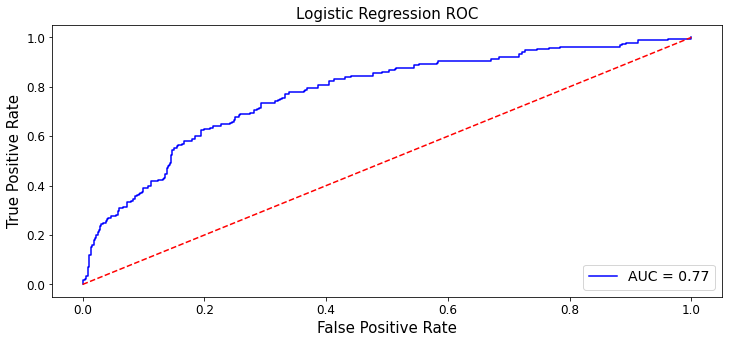

In [175]:

plt.figure(figsize=(12,5))

probaLr = sel.estimator_.predict_proba(X_test_lr)
lr_pred = probaLr[:,1]
fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(y_test_lr, lr_pred, pos_label=sel.estimator_.classes_[1])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.2f' % roc_auc_lr)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Logistic Regression ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### B. Forêt aléatoire

La forêt aléatoire ou Random Forest est un algorithme qui se base sur l’assemblage d’arbres de décision.

Il est composé d'un ensemble d'arbre de décision indépendants où chacun dispose d'une vision parcellaire du problème grâce à un double tirage aléatoire :

<ol>
    <li>Un tirage aléatoire avec remplacement sur les observations (les lignes)</li>
    <li>Un tirage aléatoire sur les variables (les colonnes)</li>
</ol>

A la fin, tous ces arbres de décisions indépendants sont assemblés. La prédiction faite par le Random Forest pour des données inconnues est alors la moyenne (ou le vote, dans le cas d'un problème de classification) de tous les arbres.

![Random Forest](https://blog.ysance.com/hs-fs/hubfs/sche%CC%81ma.gif?width=1962&name=sche%CC%81ma.gif)

Implémentation de l'algorithme de foret aléatoire `random Forest`

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
X_train_forest = data_X_train_prepared.copy()
y_train_forest = y_train.copy()
X_test_forest = data_X_test_prepared.copy()
y_test_forest = y_test.copy()
forest_clf = RandomForestClassifier()

forest_param_grid = [
    {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [10, 20, 40, 50,60]}
  ]

grid_search = GridSearchCV(forest_clf, forest_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(X_train_forest, y_train_forest)



GridSearchCV(cv=7, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 20, 40, 50, 60],
                          'n_estimators': [50, 100, 200]}],
             return_train_score=True, scoring='f1')

In [177]:
print(grid_search.best_params_)
best_random_forest = grid_search.best_estimator_
print(best_random_forest)

{'max_depth': 50, 'n_estimators': 200}
RandomForestClassifier(max_depth=50, n_estimators=200)


In [178]:
forest_clf = best_random_forest
forest_clf.fit(X_train_forest,y_train_forest)

forest_pred=forest_clf.predict(X_test_forest)


Matrice de confusion

In [179]:
confusion_matrix(y_test_forest, forest_pred)

array([[1107,    3],
       [   9,  204]], dtype=int64)

Rapport de la classification

In [180]:
print(metrics.classification_report(y_test_forest, forest_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1110
           1       0.99      0.96      0.97       213

    accuracy                           0.99      1323
   macro avg       0.99      0.98      0.98      1323
weighted avg       0.99      0.99      0.99      1323



In [181]:
cross_val_score(forest_clf, X_train_forest, y_train_forest, cv=3, scoring="accuracy")

array([0.95043732, 0.94071914, 0.95136187])

Création de la courbre ROC

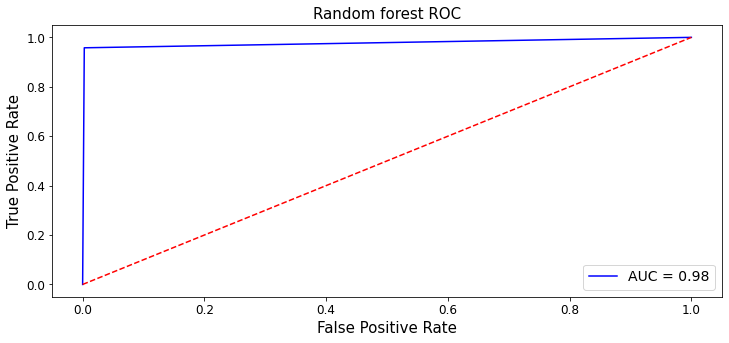

In [182]:
plt.figure(figsize=(12,5))

fpr_rdm_forest, tpr_rdm_forest, threshold_rdm_forest = metrics.roc_curve(y_test_forest, forest_pred)
roc_auc_rdm_forest = metrics.auc(fpr_rdm_forest, tpr_rdm_forest)

plt.plot(fpr_rdm_forest, tpr_rdm_forest, 'b', label = 'AUC = %0.2f' % roc_auc_rdm_forest)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Random forest ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### C. Arbre de décision

<p> L'algorithme d'arbre de décision est une méthode d'apprentissage supervisé non paramétrique utilisée pour la classification. <br>
L'objectif est de créer un modèle qui prédit la valeur d'une variable cible en apprenant des règles de décision simples déduites des caractéristiques des données. <br>

`DecisionTreeClassifierprend` en entrée deux tableaux : un tableau `X_train_tree` qui est de forme contenant les échantillons d'apprentissage, et un tableau `y_train_tree` de valeurs entières, forme , contenant les étiquettes de classe pour les échantillons d'apprentissage.

<p>Implémentation de l'algorithme d'arbre de décision

In [183]:
from sklearn.tree import DecisionTreeClassifier
X_train_tree = data_X_train_prepared.copy()
y_train_tree = y_train.copy()
X_test_tree = data_X_test_prepared.copy()
y_test_tree = y_test.copy()
tree = DecisionTreeClassifier()
tree_param_grid = [{'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}]

grid_search = GridSearchCV(tree, tree_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(X_train_tree, y_train_tree)

GridSearchCV(cv=7, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]}],
             return_train_score=True, scoring='f1')

In [184]:
print(grid_search.best_params_)
best_decision_tree = grid_search.best_estimator_
print(best_decision_tree)

{'max_leaf_nodes': 99, 'min_samples_split': 3}
DecisionTreeClassifier(max_leaf_nodes=99, min_samples_split=3)


In [185]:
tree = best_decision_tree
tree = tree.fit(X_train_tree, y_train_tree)
tree.score(X_train_tree, y_train_tree)

0.9497731691510045

<p>Visualisation du graphique avec la librairie GraphViz

In [186]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="arbre.dot", filled=True, feature_names= X_train_tree.columns)

In [187]:
conda install python-graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [188]:
!dot -Tpng arbre.dot -o arbre.png

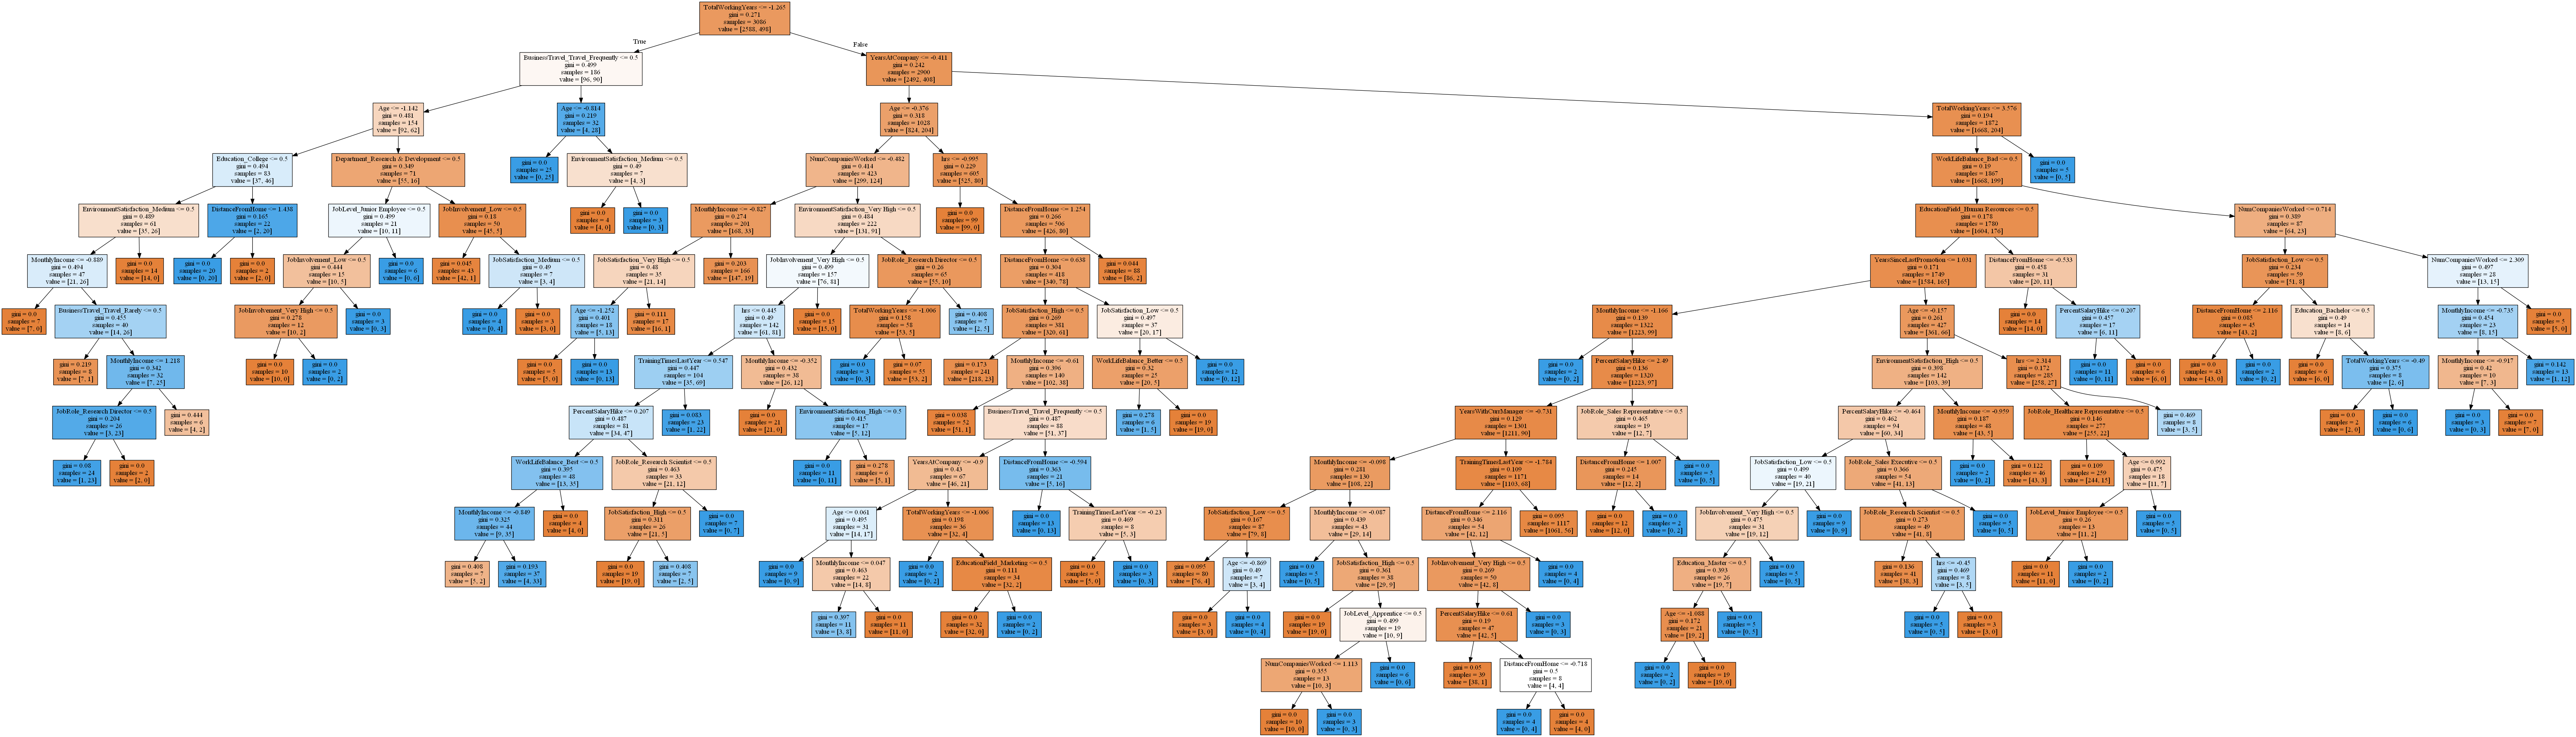

In [189]:
from IPython.core.display import Image
Image("arbre.png")

<p>Cross validation

In [190]:
tree_pred = tree.predict(X_test_tree)

In [191]:
from sklearn.model_selection import cross_val_score
cross_val_score(tree, X_train_tree, y_train_tree, cv=3, scoring="accuracy")

array([0.88824101, 0.85034014, 0.90661479])

<p>Matrice de confusion

In [192]:
confusion_matrix(y_test_tree, tree_pred)

array([[1080,   30],
       [ 100,  113]], dtype=int64)

<p>Rapport de la classification

In [193]:
print(metrics.classification_report(y_test_tree, tree_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1110
           1       0.79      0.53      0.63       213

    accuracy                           0.90      1323
   macro avg       0.85      0.75      0.79      1323
weighted avg       0.90      0.90      0.89      1323



<p>Création de la courbre ROC

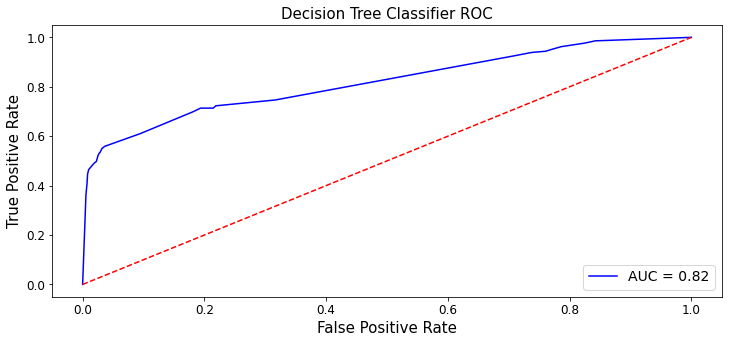

In [194]:
plt.figure(figsize=(12,5))

probaTree = tree.predict_proba(X_test_tree)
tree_test_pred = probaTree[:,1]
fpr_tree, tpr_tree, threshold_tree = metrics.roc_curve(y_test_tree, tree_test_pred, pos_label=tree.classes_[1])
roc_auc_tree = metrics.auc(fpr_tree, tpr_tree)

plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC = %0.2f' % roc_auc_tree)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Decision Tree Classifier ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### D. SVC (Support Vector Classifier) 

Un  SVM  est  un  algorithme  utilisant  la  composante  vectorielle  des  éléments  du  jeu  de données d’apprentissage afin d’en déterminer une orientation préférentielle. Ainsi selon que l’on se place dans un contexte de régression ou de classification, il va être possible de :
* Soitdéfinir une  droite  portéepar  cette  orientation  donnée  par  la  composante vectorielle 
*  Soitde  construire  une  droite  perpendiculaire  à  ce  même  vecteur  (et  placer  à équidistancedes ensembles à séparer)

<p>Implémentation de l'algorithme Support Vector Classifier

In [195]:
from sklearn.svm import SVC

sv = SVC(probability=True) #Create a svm Classifier
X_train_svc = data_X_train_prepared.copy()
y_train_svc = y_train.copy()
X_test_svc = data_X_test_prepared.copy()
y_test_svc = y_test.copy()

svc_param_grid =  {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid_search = GridSearchCV(sv, svc_param_grid, cv=7,
                           scoring='f1', return_train_score=True)
grid_search.fit(X_train_svc, y_train_svc)

GridSearchCV(cv=7, estimator=SVC(probability=True),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             return_train_score=True, scoring='f1')

In [196]:
print(grid_search.best_params_)
best_svc = grid_search.best_estimator_
print(best_svc)

{'C': 10, 'kernel': 'rbf'}
SVC(C=10, probability=True)


In [197]:
sv = best_svc
sv.fit(X_train_svc, y_train)

SVC(C=10, probability=True)

In [198]:
svc_pred = sv.predict(X_test_svc)
cross_val_score(sv, X_train_svc, y_train_svc, cv=3, scoring="accuracy")

array([0.95140914, 0.92031098, 0.93968872])

<p>Matrice de confusion

In [199]:
confusion_matrix(y_test_svc, svc_pred)

array([[1104,    6],
       [  11,  202]], dtype=int64)

<p>Rapport de la classification

In [200]:
print(metrics.classification_report(y_test_svc, svc_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1110
           1       0.97      0.95      0.96       213

    accuracy                           0.99      1323
   macro avg       0.98      0.97      0.98      1323
weighted avg       0.99      0.99      0.99      1323



<p>Création de la courbre ROC

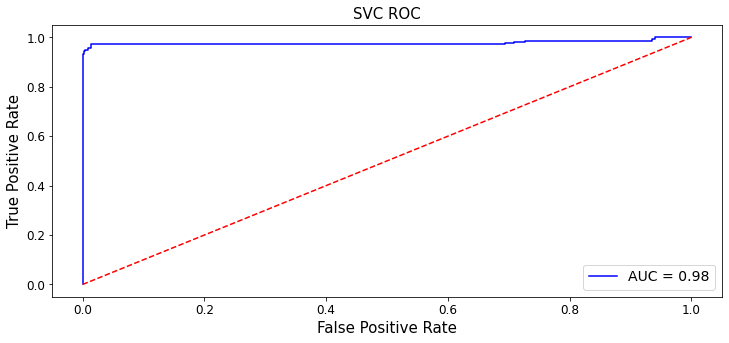

In [201]:
plt.figure(figsize=(12,5))

probaSVC = sv.predict_proba(X_test_svc)
svc_pred = probaSVC[:,1]
fpr_svc, tpr_svc, threshold_svc = metrics.roc_curve(y_test_svc, svc_pred, pos_label=sv.classes_[1])
roc_auc_svc = metrics.auc(fpr_svc, tpr_svc)

plt.plot(fpr_svc, tpr_svc, 'b', label = 'AUC = %0.2f' % roc_auc_svc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('SVC ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

### E. Classements de tous les algorithmes

Maintenant que nous avons testés nos différents modèles, nous allons les comparers selon les résultats de leurs performances. 

| Algorithmes | Valeur AUC | False Negatif | False Positif |
| ------- | --- | --- | --- |
|   1. Random Forest   | <span style="color:#33FF3B">0.98</span> | <span style="color:#33FF3B">9</span> | <span style="color:#33FF3B">3</span> |
|   2. SVC   | <span style="color:#33FF3B">0.98</span> | 11 | 6 |
|   3. Arbre de décision  | 0.82 | 100 | 30 |
|  4. Régression Logistique  | 0.77 | 179 | 21 |

Le false negatif correspond au nombre d'employés qui, selon le modèle, restent dans la compagnie alors qu'ils risquent de partir.

Le false positif est bien entendu l'opposé, c'est-à-dire que l'employé est décrit comme un employé risquant de partir alors qu'il compte rester dans l'entreprise.

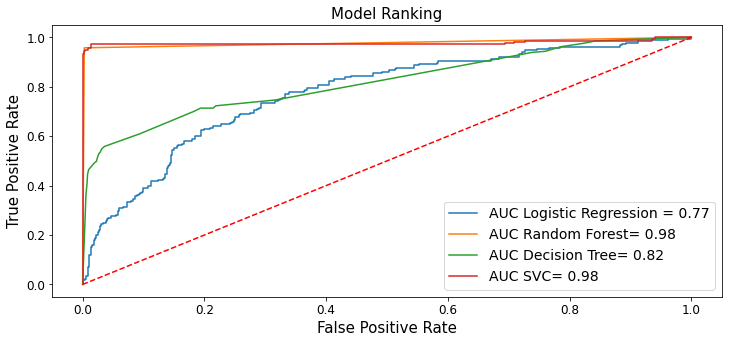

In [202]:
plt.figure(figsize=(12,5))
plt.plot(fpr_lr, tpr_lr, label = 'AUC Logistic Regression = %0.2f' % roc_auc_lr)
plt.plot(fpr_rdm_forest, tpr_rdm_forest, label = 'AUC Random Forest= %0.2f' % roc_auc_rdm_forest)
plt.plot(fpr_tree, tpr_tree, label = 'AUC Decision Tree= %0.2f' % roc_auc_tree)
plt.plot(fpr_svc, tpr_svc, label = 'AUC SVC= %0.2f' % roc_auc_svc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Model Ranking', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()

## 5. Résultats

In [203]:
X_prepared = full_pipeline.fit_transform(X)
X_prepared = pd.DataFrame(
    X_prepared,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(cat_attribs)))))
y_prepared = y.copy()

forest_clf.fit(X_prepared,y_prepared)

RandomForestClassifier(max_depth=50, n_estimators=200)

Text(0.5, 0, 'Relative Importance')

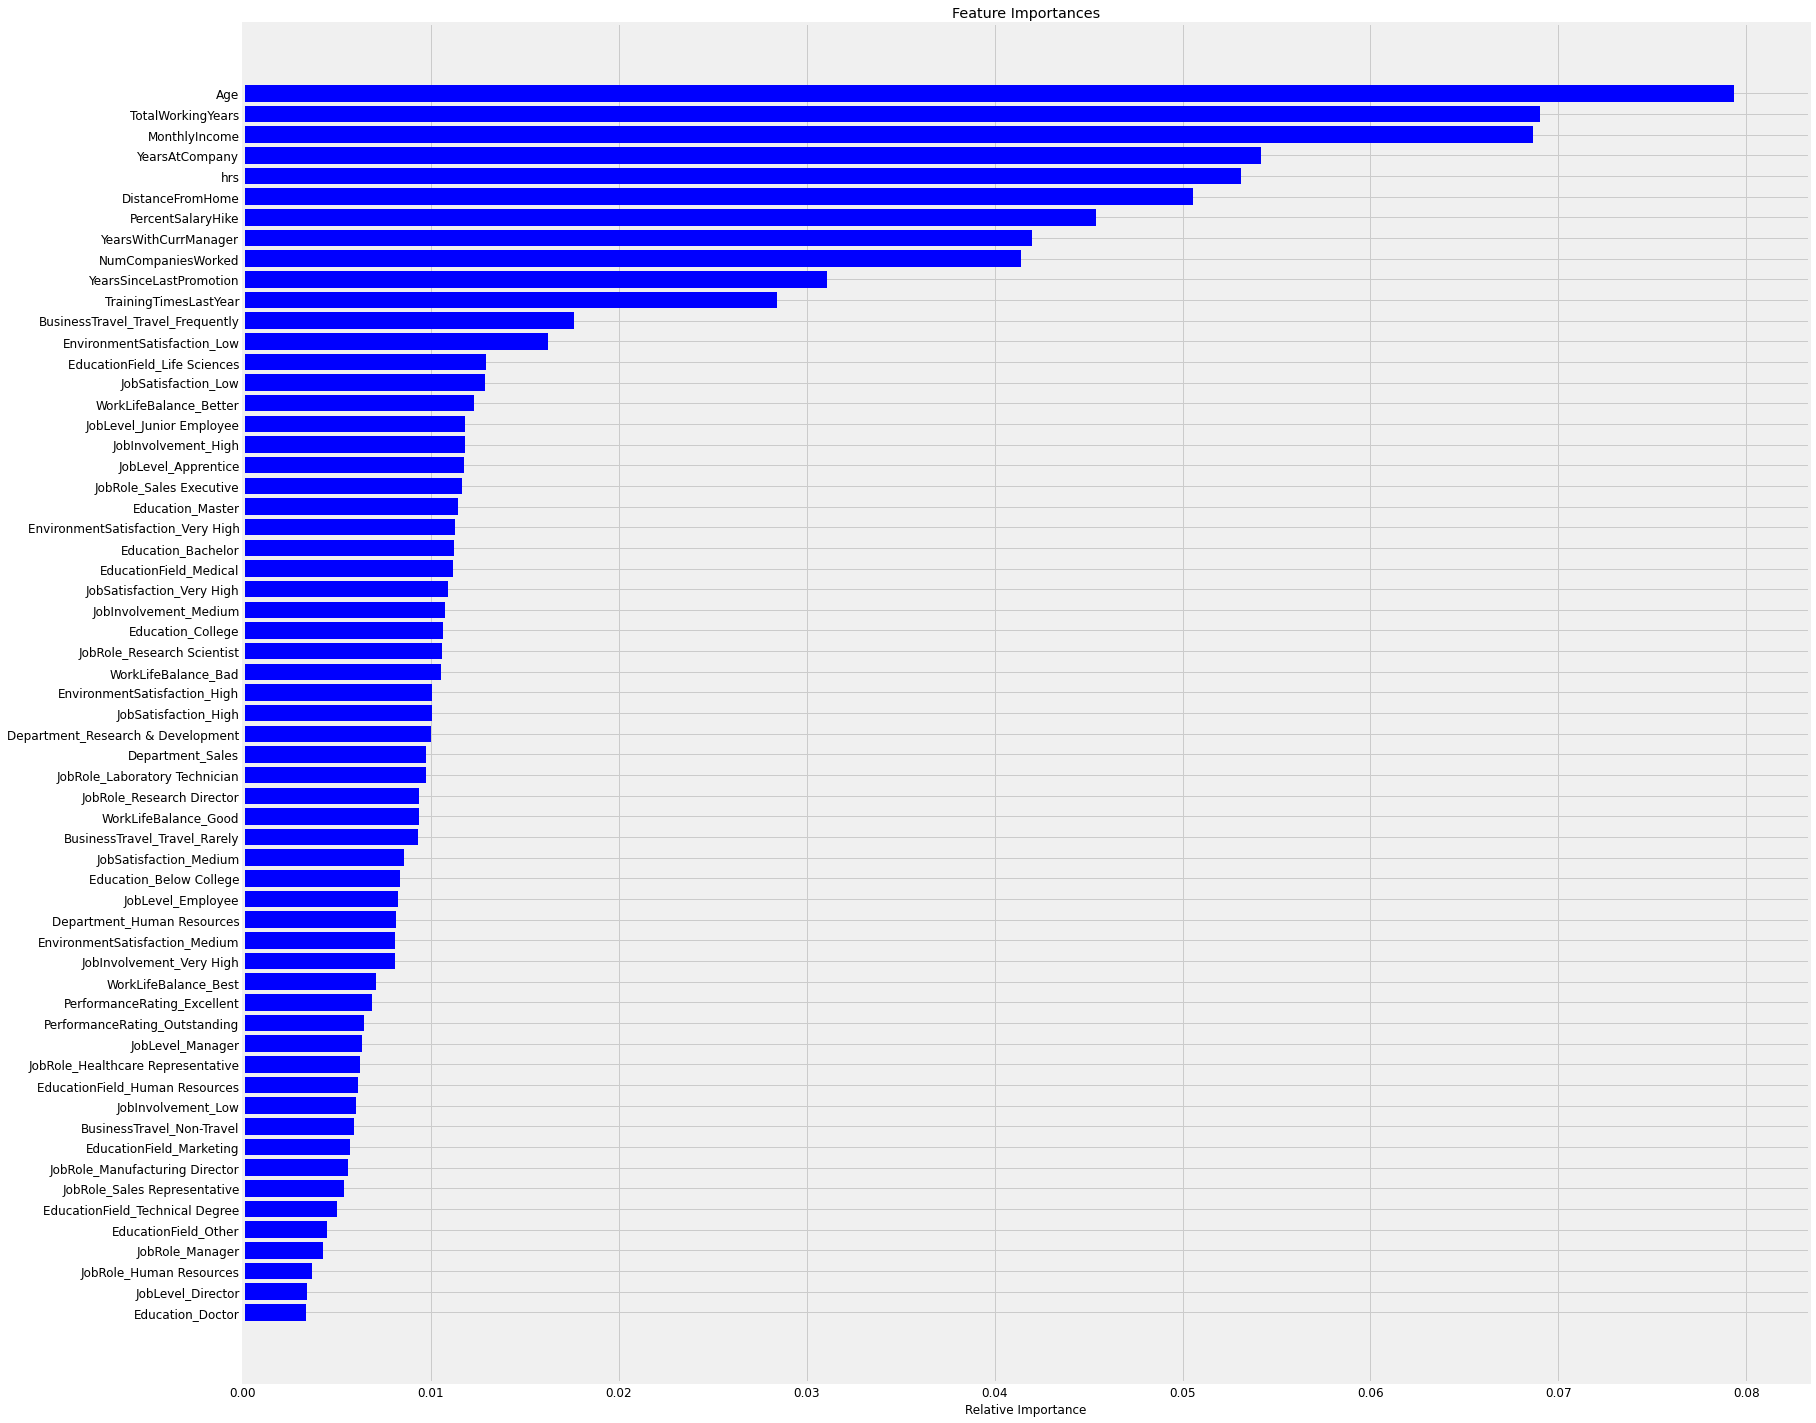

In [204]:
importances = forest_clf.feature_importances_
indices = np.argsort(importances)
# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(figsize=(25,25))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_prepared.columns[i] for i in indices])
plt.xlabel('Relative Importance')

Ce graphe nous indique quelles variables ont une importance dans la décision de quitter l'entreprise. Pour rester dans l'acceptable, on va prendre toutes les variables jusqu'à `TrainingTimesLastYear`. On considère que les autres variables n'ont pas assez d'importance. Avoir la liste des variables est bien sympathique mais en soit, cela ne nous apporte pas grand chose. On sait que l'age est très utile mais qui part? Les jeunes ou les personnes plus agées?
C'est pour cela que nous allons refaire nos boîtes à moustache ou nos bar diagrammes. On va pouvoir faire une liaison entre les variables importantes et les données concrêtes pour savoir qui quitte l'entreprise.

### Age

Text(0.5, 0.98, '')

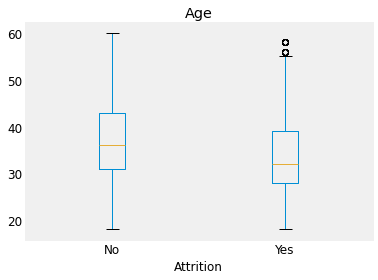

In [205]:
allData.boxplot(by ='Attrition', column = "Age", grid = False, figsize=None) 
plt.suptitle("")

### TotalWorkingYears

Text(0.5, 0.98, '')

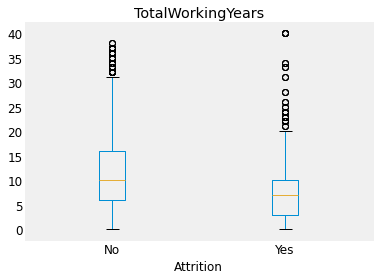

In [206]:
allData.boxplot(by ='Attrition', column = "TotalWorkingYears", grid = False, figsize=None) 
plt.suptitle("")

### MonthlyIncome

Text(0.5, 0.98, '')

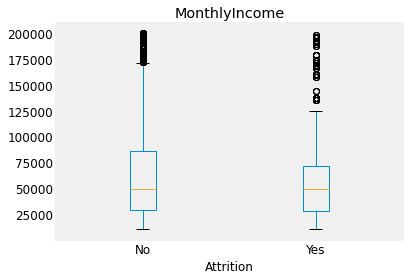

In [207]:
allData.boxplot(by ='Attrition', column = "MonthlyIncome", grid = False, figsize=None) 
plt.suptitle("")

### YearsAtCompany

Text(0.5, 0.98, '')

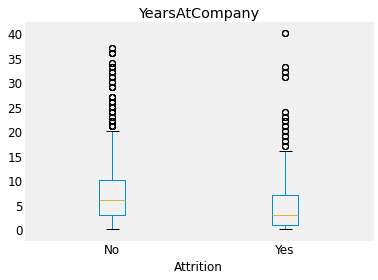

In [208]:
allData.boxplot(by ='Attrition', column = "YearsAtCompany", grid = False, figsize=None) 
plt.suptitle("")

### Hours

Text(0.5, 0.98, '')

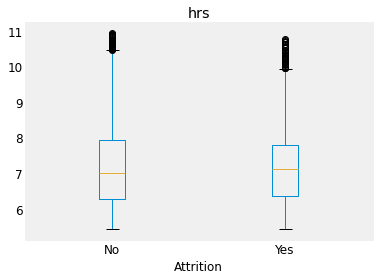

In [211]:
allData.boxplot(by ='Attrition', column = "hrs", grid = False, figsize=None) 
plt.suptitle("")

### DistanceFromHome

Text(0.5, 0.98, '')

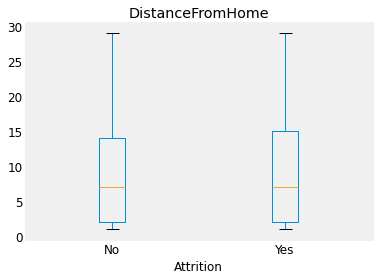

In [212]:
allData.boxplot(by ='Attrition', column = "DistanceFromHome", grid = False, figsize=None) 
plt.suptitle("")

### PercentSalaryHike

Text(0.5, 0.98, '')

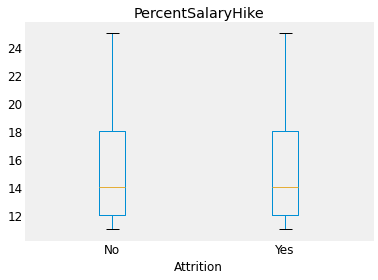

In [217]:
allData.boxplot(by ='Attrition', column = "PercentSalaryHike", grid = False, figsize=None) 
plt.suptitle("")

### YearsWithCurrManager

Text(0.5, 0.98, '')

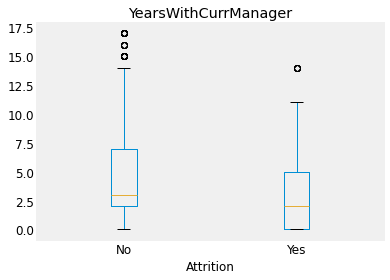

In [219]:
allData.boxplot(by ='Attrition', column = "YearsWithCurrManager", grid = False, figsize=None) 
plt.suptitle("")

### NumCompaniesWorked

### YearsSinceLastPromotion

### TrainingTimesLastYear